In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install gym/[all]`.

In [6]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [7]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [8]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [10]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [11]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [13]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [15]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [16]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [17]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                    model.g_opt, model.d_optA], #, model.d_optQ
                                                   feed_dict = {model.states: states, 
                                                                model.actions: actions,
                                                                model.targetQs: targetQs, 
                                                                model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:0.7675 dlossA:0.7475 dlossQ:0.9213 exploreP:0.9981
Episode:1 meanR:20.0000 R:21.0000 rate:0.0420 gloss:0.7488 dlossA:0.7385 dlossQ:0.9226 exploreP:0.9960
Episode:2 meanR:39.6667 R:79.0000 rate:0.1580 gloss:0.7440 dlossA:0.7310 dlossQ:0.9353 exploreP:0.9883
Episode:3 meanR:39.5000 R:39.0000 rate:0.0780 gloss:0.7102 dlossA:0.7148 dlossQ:0.9416 exploreP:0.9845
Episode:4 meanR:34.6000 R:15.0000 rate:0.0300 gloss:0.7035 dlossA:0.7095 dlossQ:0.9450 exploreP:0.9830
Episode:5 meanR:37.5000 R:52.0000 rate:0.1040 gloss:0.6812 dlossA:0.6967 dlossQ:0.9486 exploreP:0.9780
Episode:6 meanR:39.7143 R:53.0000 rate:0.1060 gloss:0.6610 dlossA:0.6854 dlossQ:0.9543 exploreP:0.9729
Episode:7 meanR:37.6250 R:23.0000 rate:0.0460 gloss:0.6264 dlossA:0.6665 dlossQ:0.9546 exploreP:0.9706
Episode:8 meanR:36.0000 R:23.0000 rate:0.0460 gloss:0.6413 dlossA:0.6766 dlossQ:0.9544 exploreP:0.9684
Episode:9 meanR:33.9000 R:15.0000 rate:0.0300 gloss:0.6488 dlossA:0.6784 

Episode:79 meanR:26.4875 R:14.0000 rate:0.0280 gloss:-0.2549 dlossA:0.3790 dlossQ:1.3373 exploreP:0.8110
Episode:80 meanR:26.4198 R:21.0000 rate:0.0420 gloss:-0.3144 dlossA:0.4091 dlossQ:1.3147 exploreP:0.8093
Episode:81 meanR:26.3659 R:22.0000 rate:0.0440 gloss:-0.2363 dlossA:0.4120 dlossQ:1.3166 exploreP:0.8075
Episode:82 meanR:26.2651 R:18.0000 rate:0.0360 gloss:-0.2827 dlossA:0.4042 dlossQ:1.3296 exploreP:0.8061
Episode:83 meanR:26.1548 R:17.0000 rate:0.0340 gloss:-0.2991 dlossA:0.3903 dlossQ:1.3757 exploreP:0.8047
Episode:84 meanR:26.2000 R:30.0000 rate:0.0600 gloss:-0.2486 dlossA:0.4060 dlossQ:1.3328 exploreP:0.8024
Episode:85 meanR:26.1628 R:23.0000 rate:0.0460 gloss:-0.3016 dlossA:0.4116 dlossQ:1.3563 exploreP:0.8005
Episode:86 meanR:26.0000 R:12.0000 rate:0.0240 gloss:-0.3021 dlossA:0.4049 dlossQ:1.3542 exploreP:0.7996
Episode:87 meanR:25.7955 R:8.0000 rate:0.0160 gloss:-0.2598 dlossA:0.3852 dlossQ:1.3991 exploreP:0.7990
Episode:88 meanR:25.6404 R:12.0000 rate:0.0240 gloss:-0.

Episode:157 meanR:20.0300 R:14.0000 rate:0.0280 gloss:-10.1152 dlossA:0.3459 dlossQ:1.0745 exploreP:0.7064
Episode:158 meanR:19.7500 R:10.0000 rate:0.0200 gloss:-11.1960 dlossA:0.3675 dlossQ:1.0652 exploreP:0.7057
Episode:159 meanR:19.7300 R:11.0000 rate:0.0220 gloss:-11.3027 dlossA:0.4026 dlossQ:1.0143 exploreP:0.7049
Episode:160 meanR:19.7000 R:11.0000 rate:0.0220 gloss:-11.5884 dlossA:0.3883 dlossQ:1.0785 exploreP:0.7042
Episode:161 meanR:19.3800 R:10.0000 rate:0.0200 gloss:-11.5759 dlossA:0.4343 dlossQ:1.0870 exploreP:0.7035
Episode:162 meanR:19.3900 R:16.0000 rate:0.0320 gloss:-10.2323 dlossA:0.3688 dlossQ:1.1840 exploreP:0.7024
Episode:163 meanR:19.2100 R:14.0000 rate:0.0280 gloss:-10.6517 dlossA:0.3851 dlossQ:1.1381 exploreP:0.7014
Episode:164 meanR:19.1300 R:14.0000 rate:0.0280 gloss:-11.0346 dlossA:0.3905 dlossQ:1.1036 exploreP:0.7004
Episode:165 meanR:19.3300 R:39.0000 rate:0.0780 gloss:-12.1765 dlossA:0.3969 dlossQ:1.1504 exploreP:0.6977
Episode:166 meanR:19.1600 R:10.0000 r

Episode:234 meanR:16.8400 R:12.0000 rate:0.0240 gloss:-43.8661 dlossA:0.4130 dlossQ:1.1345 exploreP:0.6198
Episode:235 meanR:17.3500 R:67.0000 rate:0.1340 gloss:-40.7539 dlossA:0.3823 dlossQ:1.1371 exploreP:0.6157
Episode:236 meanR:17.4000 R:15.0000 rate:0.0300 gloss:-44.3330 dlossA:0.3774 dlossQ:1.0579 exploreP:0.6148
Episode:237 meanR:17.3900 R:11.0000 rate:0.0220 gloss:-47.9061 dlossA:0.3624 dlossQ:1.0089 exploreP:0.6141
Episode:238 meanR:17.4400 R:14.0000 rate:0.0280 gloss:-49.4585 dlossA:0.3971 dlossQ:1.0219 exploreP:0.6133
Episode:239 meanR:17.4900 R:14.0000 rate:0.0280 gloss:-39.6029 dlossA:0.3757 dlossQ:1.1510 exploreP:0.6125
Episode:240 meanR:17.4400 R:10.0000 rate:0.0200 gloss:-47.6132 dlossA:0.3638 dlossQ:1.0428 exploreP:0.6118
Episode:241 meanR:17.3400 R:17.0000 rate:0.0340 gloss:-51.6325 dlossA:0.3951 dlossQ:1.0234 exploreP:0.6108
Episode:242 meanR:17.3800 R:14.0000 rate:0.0280 gloss:-39.8800 dlossA:0.3789 dlossQ:1.1709 exploreP:0.6100
Episode:243 meanR:17.2400 R:9.0000 ra

Episode:311 meanR:15.4500 R:15.0000 rate:0.0300 gloss:-84.7628 dlossA:0.3843 dlossQ:1.2521 exploreP:0.5503
Episode:312 meanR:15.4000 R:9.0000 rate:0.0180 gloss:-108.0698 dlossA:0.3845 dlossQ:1.0447 exploreP:0.5498
Episode:313 meanR:15.4100 R:21.0000 rate:0.0420 gloss:-98.4084 dlossA:0.3802 dlossQ:1.0837 exploreP:0.5487
Episode:314 meanR:15.3200 R:10.0000 rate:0.0200 gloss:-103.8420 dlossA:0.3905 dlossQ:1.1084 exploreP:0.5481
Episode:315 meanR:15.3100 R:11.0000 rate:0.0220 gloss:-92.6905 dlossA:0.3755 dlossQ:1.1951 exploreP:0.5475
Episode:316 meanR:15.2900 R:12.0000 rate:0.0240 gloss:-116.3836 dlossA:0.3583 dlossQ:0.9997 exploreP:0.5469
Episode:317 meanR:15.2800 R:17.0000 rate:0.0340 gloss:-107.8786 dlossA:0.3906 dlossQ:1.0831 exploreP:0.5460
Episode:318 meanR:15.2700 R:16.0000 rate:0.0320 gloss:-110.5470 dlossA:0.3664 dlossQ:1.1351 exploreP:0.5451
Episode:319 meanR:15.1700 R:9.0000 rate:0.0180 gloss:-108.2002 dlossA:0.3693 dlossQ:1.0966 exploreP:0.5446
Episode:320 meanR:15.1600 R:15.00

Episode:388 meanR:13.6800 R:12.0000 rate:0.0240 gloss:-156.0411 dlossA:0.3720 dlossQ:1.2696 exploreP:0.4963
Episode:389 meanR:13.8000 R:26.0000 rate:0.0520 gloss:-216.8078 dlossA:0.3736 dlossQ:1.0648 exploreP:0.4950
Episode:390 meanR:13.7700 R:11.0000 rate:0.0220 gloss:-179.1007 dlossA:0.3934 dlossQ:1.1467 exploreP:0.4945
Episode:391 meanR:13.7500 R:11.0000 rate:0.0220 gloss:-170.4941 dlossA:0.4054 dlossQ:1.2980 exploreP:0.4940
Episode:392 meanR:13.7300 R:10.0000 rate:0.0200 gloss:-168.9406 dlossA:0.4052 dlossQ:1.2060 exploreP:0.4935
Episode:393 meanR:13.7400 R:13.0000 rate:0.0260 gloss:-170.6272 dlossA:0.3757 dlossQ:1.2887 exploreP:0.4928
Episode:394 meanR:13.7200 R:10.0000 rate:0.0200 gloss:-209.1181 dlossA:0.3919 dlossQ:0.9866 exploreP:0.4924
Episode:395 meanR:13.6100 R:11.0000 rate:0.0220 gloss:-182.5229 dlossA:0.3793 dlossQ:1.1203 exploreP:0.4918
Episode:396 meanR:13.6400 R:14.0000 rate:0.0280 gloss:-191.5340 dlossA:0.3779 dlossQ:1.1921 exploreP:0.4912
Episode:397 meanR:13.6500 R:

Episode:464 meanR:13.5500 R:13.0000 rate:0.0260 gloss:-252.3365 dlossA:0.3948 dlossQ:1.2115 exploreP:0.4499
Episode:465 meanR:13.5600 R:14.0000 rate:0.0280 gloss:-333.5944 dlossA:0.3815 dlossQ:1.1246 exploreP:0.4493
Episode:466 meanR:13.4900 R:10.0000 rate:0.0200 gloss:-248.8007 dlossA:0.4326 dlossQ:1.2985 exploreP:0.4488
Episode:467 meanR:13.5000 R:19.0000 rate:0.0380 gloss:-289.3574 dlossA:0.4109 dlossQ:1.2089 exploreP:0.4480
Episode:468 meanR:13.4500 R:11.0000 rate:0.0220 gloss:-310.4630 dlossA:0.3489 dlossQ:1.1285 exploreP:0.4475
Episode:469 meanR:13.4600 R:9.0000 rate:0.0180 gloss:-376.6898 dlossA:0.3726 dlossQ:0.9862 exploreP:0.4471
Episode:470 meanR:13.3800 R:10.0000 rate:0.0200 gloss:-291.8041 dlossA:0.3746 dlossQ:1.0923 exploreP:0.4467
Episode:471 meanR:13.3800 R:10.0000 rate:0.0200 gloss:-331.9218 dlossA:0.4228 dlossQ:1.1515 exploreP:0.4462
Episode:472 meanR:13.3700 R:9.0000 rate:0.0180 gloss:-271.7763 dlossA:0.3613 dlossQ:1.2978 exploreP:0.4459
Episode:473 meanR:13.3700 R:9.

Episode:540 meanR:12.6300 R:11.0000 rate:0.0220 gloss:-492.1066 dlossA:0.3900 dlossQ:1.1331 exploreP:0.4105
Episode:541 meanR:12.6100 R:9.0000 rate:0.0180 gloss:-534.4886 dlossA:0.3595 dlossQ:1.0629 exploreP:0.4101
Episode:542 meanR:12.5900 R:10.0000 rate:0.0200 gloss:-462.6577 dlossA:0.3867 dlossQ:1.2151 exploreP:0.4097
Episode:543 meanR:12.4500 R:13.0000 rate:0.0260 gloss:-467.7881 dlossA:0.3875 dlossQ:1.1251 exploreP:0.4092
Episode:544 meanR:12.4400 R:11.0000 rate:0.0220 gloss:-405.8661 dlossA:0.4068 dlossQ:1.3049 exploreP:0.4088
Episode:545 meanR:12.4100 R:8.0000 rate:0.0160 gloss:-524.7086 dlossA:0.4096 dlossQ:1.0367 exploreP:0.4085
Episode:546 meanR:12.4200 R:10.0000 rate:0.0200 gloss:-410.3139 dlossA:0.3758 dlossQ:1.3151 exploreP:0.4081
Episode:547 meanR:12.4700 R:18.0000 rate:0.0360 gloss:-549.3046 dlossA:0.3753 dlossQ:1.0840 exploreP:0.4073
Episode:548 meanR:12.4800 R:14.0000 rate:0.0280 gloss:-421.7852 dlossA:0.4067 dlossQ:1.2734 exploreP:0.4068
Episode:549 meanR:12.4100 R:11

Episode:616 meanR:13.0700 R:17.0000 rate:0.0340 gloss:-685.1533 dlossA:0.3686 dlossQ:1.2145 exploreP:0.3721
Episode:617 meanR:13.0200 R:12.0000 rate:0.0240 gloss:-683.2703 dlossA:0.3819 dlossQ:1.1636 exploreP:0.3717
Episode:618 meanR:13.0100 R:10.0000 rate:0.0200 gloss:-555.1417 dlossA:0.4225 dlossQ:1.4052 exploreP:0.3713
Episode:619 meanR:13.0100 R:9.0000 rate:0.0180 gloss:-677.3514 dlossA:0.3902 dlossQ:1.2231 exploreP:0.3710
Episode:620 meanR:13.0300 R:10.0000 rate:0.0200 gloss:-726.3396 dlossA:0.3588 dlossQ:1.1004 exploreP:0.3706
Episode:621 meanR:13.0800 R:14.0000 rate:0.0280 gloss:-652.7518 dlossA:0.3963 dlossQ:1.2071 exploreP:0.3701
Episode:622 meanR:12.9900 R:10.0000 rate:0.0200 gloss:-655.0594 dlossA:0.3809 dlossQ:1.2322 exploreP:0.3697
Episode:623 meanR:12.9600 R:11.0000 rate:0.0220 gloss:-501.4866 dlossA:0.4272 dlossQ:1.4745 exploreP:0.3694
Episode:624 meanR:12.9500 R:9.0000 rate:0.0180 gloss:-705.2214 dlossA:0.3956 dlossQ:1.1852 exploreP:0.3690
Episode:625 meanR:12.9500 R:13

Episode:692 meanR:11.7800 R:9.0000 rate:0.0180 gloss:-830.6215 dlossA:0.3910 dlossQ:1.2545 exploreP:0.3420
Episode:693 meanR:11.7500 R:9.0000 rate:0.0180 gloss:-1081.5830 dlossA:0.4041 dlossQ:1.0857 exploreP:0.3417
Episode:694 meanR:11.6800 R:11.0000 rate:0.0220 gloss:-1034.7570 dlossA:0.3794 dlossQ:1.1472 exploreP:0.3413
Episode:695 meanR:11.6500 R:15.0000 rate:0.0300 gloss:-802.5306 dlossA:0.3922 dlossQ:1.3196 exploreP:0.3408
Episode:696 meanR:11.6800 R:13.0000 rate:0.0260 gloss:-816.6595 dlossA:0.3770 dlossQ:1.2340 exploreP:0.3404
Episode:697 meanR:11.6500 R:12.0000 rate:0.0240 gloss:-878.0836 dlossA:0.3906 dlossQ:1.3277 exploreP:0.3400
Episode:698 meanR:11.5700 R:12.0000 rate:0.0240 gloss:-1010.3976 dlossA:0.3847 dlossQ:1.0762 exploreP:0.3396
Episode:699 meanR:11.5500 R:10.0000 rate:0.0200 gloss:-930.2787 dlossA:0.3659 dlossQ:1.2884 exploreP:0.3392
Episode:700 meanR:11.6100 R:14.0000 rate:0.0280 gloss:-1053.7400 dlossA:0.3928 dlossQ:1.2625 exploreP:0.3388
Episode:701 meanR:11.5800 

Episode:768 meanR:11.4200 R:12.0000 rate:0.0240 gloss:-1494.8888 dlossA:0.3664 dlossQ:1.2105 exploreP:0.3146
Episode:769 meanR:11.3700 R:11.0000 rate:0.0220 gloss:-1386.5547 dlossA:0.3128 dlossQ:1.0968 exploreP:0.3143
Episode:770 meanR:11.3500 R:12.0000 rate:0.0240 gloss:-1220.5197 dlossA:0.3789 dlossQ:1.1947 exploreP:0.3139
Episode:771 meanR:11.3300 R:11.0000 rate:0.0220 gloss:-1138.0127 dlossA:0.3733 dlossQ:1.3035 exploreP:0.3136
Episode:772 meanR:11.3400 R:12.0000 rate:0.0240 gloss:-1326.7996 dlossA:0.3499 dlossQ:1.1757 exploreP:0.3132
Episode:773 meanR:11.3200 R:11.0000 rate:0.0220 gloss:-1313.6980 dlossA:0.3764 dlossQ:1.1613 exploreP:0.3129
Episode:774 meanR:11.3500 R:12.0000 rate:0.0240 gloss:-1146.3031 dlossA:0.3892 dlossQ:1.3161 exploreP:0.3125
Episode:775 meanR:11.3200 R:9.0000 rate:0.0180 gloss:-1075.2716 dlossA:0.3682 dlossQ:1.2831 exploreP:0.3123
Episode:776 meanR:11.2700 R:8.0000 rate:0.0160 gloss:-1376.4927 dlossA:0.3823 dlossQ:1.1817 exploreP:0.3120
Episode:777 meanR:11.

Episode:844 meanR:11.3000 R:13.0000 rate:0.0260 gloss:-1632.3817 dlossA:0.3916 dlossQ:1.1401 exploreP:0.2899
Episode:845 meanR:11.3200 R:12.0000 rate:0.0240 gloss:-1707.0162 dlossA:0.3527 dlossQ:1.1304 exploreP:0.2896
Episode:846 meanR:11.3500 R:12.0000 rate:0.0240 gloss:-1811.6040 dlossA:0.3461 dlossQ:1.1205 exploreP:0.2892
Episode:847 meanR:11.2300 R:9.0000 rate:0.0180 gloss:-1183.2559 dlossA:0.4386 dlossQ:1.4609 exploreP:0.2890
Episode:848 meanR:11.2600 R:12.0000 rate:0.0240 gloss:-2010.2910 dlossA:0.3496 dlossQ:1.0302 exploreP:0.2886
Episode:849 meanR:11.1900 R:10.0000 rate:0.0200 gloss:-1958.5208 dlossA:0.3705 dlossQ:1.2268 exploreP:0.2884
Episode:850 meanR:11.2100 R:11.0000 rate:0.0220 gloss:-1648.1840 dlossA:0.3855 dlossQ:1.2624 exploreP:0.2881
Episode:851 meanR:11.2200 R:11.0000 rate:0.0220 gloss:-1796.7491 dlossA:0.3602 dlossQ:1.1873 exploreP:0.2877
Episode:852 meanR:11.2000 R:12.0000 rate:0.0240 gloss:-1549.4994 dlossA:0.3969 dlossQ:1.2199 exploreP:0.2874
Episode:853 meanR:11

Episode:920 meanR:11.2500 R:11.0000 rate:0.0220 gloss:-1613.3988 dlossA:0.3753 dlossQ:1.3977 exploreP:0.2669
Episode:921 meanR:11.2100 R:11.0000 rate:0.0220 gloss:-2573.8501 dlossA:0.3481 dlossQ:1.1386 exploreP:0.2666
Episode:922 meanR:11.2000 R:10.0000 rate:0.0200 gloss:-2265.8374 dlossA:0.4144 dlossQ:1.3151 exploreP:0.2664
Episode:923 meanR:11.1800 R:9.0000 rate:0.0180 gloss:-2132.9895 dlossA:0.3567 dlossQ:1.2114 exploreP:0.2662
Episode:924 meanR:11.1700 R:10.0000 rate:0.0200 gloss:-2220.3235 dlossA:0.3790 dlossQ:1.2643 exploreP:0.2659
Episode:925 meanR:11.1800 R:10.0000 rate:0.0200 gloss:-3221.0920 dlossA:0.4191 dlossQ:1.1910 exploreP:0.2656
Episode:926 meanR:11.1600 R:9.0000 rate:0.0180 gloss:-2823.9094 dlossA:0.4249 dlossQ:1.5581 exploreP:0.2654
Episode:927 meanR:11.1800 R:11.0000 rate:0.0220 gloss:-2860.7944 dlossA:0.3725 dlossQ:1.9294 exploreP:0.2651
Episode:928 meanR:11.1900 R:10.0000 rate:0.0200 gloss:-2093.8892 dlossA:0.4046 dlossQ:1.5040 exploreP:0.2649
Episode:929 meanR:11.

Episode:996 meanR:11.1300 R:10.0000 rate:0.0200 gloss:-2890.0203 dlossA:0.3661 dlossQ:1.1572 exploreP:0.2462
Episode:997 meanR:11.1100 R:11.0000 rate:0.0220 gloss:-2846.0510 dlossA:0.4009 dlossQ:1.3532 exploreP:0.2459
Episode:998 meanR:11.0900 R:9.0000 rate:0.0180 gloss:-2345.5825 dlossA:0.3389 dlossQ:1.3003 exploreP:0.2457
Episode:999 meanR:11.1000 R:12.0000 rate:0.0240 gloss:-2644.8499 dlossA:0.3836 dlossQ:1.2792 exploreP:0.2454
Episode:1000 meanR:11.1000 R:10.0000 rate:0.0200 gloss:-3021.3584 dlossA:0.3247 dlossQ:1.1292 exploreP:0.2452
Episode:1001 meanR:11.1400 R:14.0000 rate:0.0280 gloss:-3186.8306 dlossA:0.3430 dlossQ:1.0939 exploreP:0.2448
Episode:1002 meanR:11.1400 R:13.0000 rate:0.0260 gloss:-2641.9648 dlossA:0.3709 dlossQ:1.2072 exploreP:0.2445
Episode:1003 meanR:11.1300 R:9.0000 rate:0.0180 gloss:-2160.4346 dlossA:0.3974 dlossQ:1.3856 exploreP:0.2443
Episode:1004 meanR:11.1600 R:12.0000 rate:0.0240 gloss:-3187.7878 dlossA:0.3552 dlossQ:1.3121 exploreP:0.2440
Episode:1005 mea

Episode:1071 meanR:10.7900 R:10.0000 rate:0.0200 gloss:-3620.7434 dlossA:0.3548 dlossQ:1.1064 exploreP:0.2278
Episode:1072 meanR:10.8000 R:11.0000 rate:0.0220 gloss:-3283.2158 dlossA:0.3559 dlossQ:1.1416 exploreP:0.2276
Episode:1073 meanR:10.7600 R:9.0000 rate:0.0180 gloss:-2773.5459 dlossA:0.4044 dlossQ:1.4018 exploreP:0.2274
Episode:1074 meanR:10.7600 R:10.0000 rate:0.0200 gloss:-2945.1016 dlossA:0.3735 dlossQ:1.2342 exploreP:0.2272
Episode:1075 meanR:10.7400 R:10.0000 rate:0.0200 gloss:-3266.4692 dlossA:0.3516 dlossQ:1.1217 exploreP:0.2269
Episode:1076 meanR:10.7000 R:9.0000 rate:0.0180 gloss:-2937.5850 dlossA:0.3714 dlossQ:1.2270 exploreP:0.2267
Episode:1077 meanR:10.7100 R:11.0000 rate:0.0220 gloss:-3371.0271 dlossA:0.3538 dlossQ:1.1422 exploreP:0.2265
Episode:1078 meanR:10.7300 R:10.0000 rate:0.0200 gloss:-2395.5508 dlossA:0.3677 dlossQ:1.9673 exploreP:0.2263
Episode:1079 meanR:10.7200 R:9.0000 rate:0.0180 gloss:-3300.1968 dlossA:0.3680 dlossQ:1.1761 exploreP:0.2261
Episode:1080 

Episode:1146 meanR:10.8200 R:12.0000 rate:0.0240 gloss:-3628.4297 dlossA:0.3938 dlossQ:1.3281 exploreP:0.2110
Episode:1147 meanR:10.8600 R:13.0000 rate:0.0260 gloss:-3595.3064 dlossA:0.3970 dlossQ:1.3315 exploreP:0.2107
Episode:1148 meanR:10.8800 R:11.0000 rate:0.0220 gloss:-3655.3999 dlossA:0.3565 dlossQ:1.2444 exploreP:0.2105
Episode:1149 meanR:10.8400 R:10.0000 rate:0.0200 gloss:-5578.5518 dlossA:0.3411 dlossQ:1.1542 exploreP:0.2103
Episode:1150 meanR:10.8400 R:11.0000 rate:0.0220 gloss:-4995.6206 dlossA:0.3964 dlossQ:1.2535 exploreP:0.2101
Episode:1151 meanR:10.8200 R:10.0000 rate:0.0200 gloss:-4538.6001 dlossA:0.3900 dlossQ:1.1883 exploreP:0.2099
Episode:1152 meanR:10.8700 R:17.0000 rate:0.0340 gloss:-4276.1436 dlossA:0.3509 dlossQ:1.4461 exploreP:0.2095
Episode:1153 meanR:10.8600 R:10.0000 rate:0.0200 gloss:-5039.7686 dlossA:0.3302 dlossQ:1.0189 exploreP:0.2093
Episode:1154 meanR:10.8700 R:10.0000 rate:0.0200 gloss:-5069.3252 dlossA:0.3410 dlossQ:1.2312 exploreP:0.2091
Episode:11

Episode:1221 meanR:10.8900 R:10.0000 rate:0.0200 gloss:-5419.4233 dlossA:0.3540 dlossQ:1.1352 exploreP:0.1951
Episode:1222 meanR:10.8800 R:8.0000 rate:0.0160 gloss:-5161.6460 dlossA:0.4123 dlossQ:1.5375 exploreP:0.1949
Episode:1223 meanR:10.8800 R:10.0000 rate:0.0200 gloss:-4549.5654 dlossA:0.3396 dlossQ:1.2622 exploreP:0.1948
Episode:1224 meanR:10.8900 R:9.0000 rate:0.0180 gloss:-5356.4668 dlossA:0.3470 dlossQ:1.1006 exploreP:0.1946
Episode:1225 meanR:10.8700 R:10.0000 rate:0.0200 gloss:-3986.0952 dlossA:0.3662 dlossQ:1.3691 exploreP:0.1944
Episode:1226 meanR:10.8700 R:11.0000 rate:0.0220 gloss:-6202.9746 dlossA:0.3929 dlossQ:1.2284 exploreP:0.1942
Episode:1227 meanR:10.8900 R:12.0000 rate:0.0240 gloss:-5471.2202 dlossA:0.3701 dlossQ:1.3768 exploreP:0.1940
Episode:1228 meanR:10.8600 R:9.0000 rate:0.0180 gloss:-3914.4639 dlossA:0.3867 dlossQ:1.3740 exploreP:0.1938
Episode:1229 meanR:10.8800 R:12.0000 rate:0.0240 gloss:-5829.1646 dlossA:0.3501 dlossQ:1.0513 exploreP:0.1936
Episode:1230 

Episode:1296 meanR:10.6900 R:13.0000 rate:0.0260 gloss:-12949.8682 dlossA:0.3726 dlossQ:3.3251 exploreP:0.1812
Episode:1297 meanR:10.6900 R:10.0000 rate:0.0200 gloss:-13820.0098 dlossA:0.3999 dlossQ:5.8445 exploreP:0.1810
Episode:1298 meanR:10.5600 R:9.0000 rate:0.0180 gloss:-6585.9473 dlossA:0.3751 dlossQ:1.3511 exploreP:0.1809
Episode:1299 meanR:10.5500 R:10.0000 rate:0.0200 gloss:-5952.5894 dlossA:0.3785 dlossQ:1.1202 exploreP:0.1807
Episode:1300 meanR:10.5600 R:11.0000 rate:0.0220 gloss:-6825.2231 dlossA:0.3493 dlossQ:1.3568 exploreP:0.1805
Episode:1301 meanR:10.5700 R:12.0000 rate:0.0240 gloss:-7012.1382 dlossA:0.3905 dlossQ:1.1862 exploreP:0.1803
Episode:1302 meanR:10.4900 R:9.0000 rate:0.0180 gloss:-7198.5024 dlossA:0.3858 dlossQ:1.5964 exploreP:0.1802
Episode:1303 meanR:10.4600 R:9.0000 rate:0.0180 gloss:-7479.6855 dlossA:0.3972 dlossQ:1.5647 exploreP:0.1800
Episode:1304 meanR:10.4900 R:12.0000 rate:0.0240 gloss:-5250.3306 dlossA:0.3902 dlossQ:1.5466 exploreP:0.1798
Episode:130

Episode:1371 meanR:10.3200 R:11.0000 rate:0.0220 gloss:-6754.1582 dlossA:0.3611 dlossQ:1.1650 exploreP:0.1684
Episode:1372 meanR:10.3200 R:10.0000 rate:0.0200 gloss:-6839.1821 dlossA:0.3652 dlossQ:1.4591 exploreP:0.1683
Episode:1373 meanR:10.3200 R:10.0000 rate:0.0200 gloss:-9150.6504 dlossA:0.3462 dlossQ:1.5490 exploreP:0.1681
Episode:1374 meanR:10.3300 R:13.0000 rate:0.0260 gloss:-5858.4697 dlossA:0.3877 dlossQ:1.2349 exploreP:0.1679
Episode:1375 meanR:10.3700 R:14.0000 rate:0.0280 gloss:-9784.5703 dlossA:0.3309 dlossQ:1.7199 exploreP:0.1677
Episode:1376 meanR:10.3200 R:10.0000 rate:0.0200 gloss:-16044.2031 dlossA:0.3985 dlossQ:6.4492 exploreP:0.1675
Episode:1377 meanR:10.3100 R:10.0000 rate:0.0200 gloss:-16667.2324 dlossA:0.5200 dlossQ:5.9023 exploreP:0.1674
Episode:1378 meanR:10.3300 R:12.0000 rate:0.0240 gloss:-17253.9316 dlossA:0.4290 dlossQ:3.4363 exploreP:0.1672
Episode:1379 meanR:10.3300 R:10.0000 rate:0.0200 gloss:-14096.1797 dlossA:0.3695 dlossQ:2.4739 exploreP:0.1670
Episod

Episode:1446 meanR:10.2500 R:10.0000 rate:0.0200 gloss:-9465.9668 dlossA:0.3379 dlossQ:1.2990 exploreP:0.1567
Episode:1447 meanR:10.2500 R:9.0000 rate:0.0180 gloss:-8301.4287 dlossA:0.3287 dlossQ:1.1326 exploreP:0.1566
Episode:1448 meanR:10.2200 R:9.0000 rate:0.0180 gloss:-8922.9541 dlossA:0.3717 dlossQ:1.1241 exploreP:0.1564
Episode:1449 meanR:10.2400 R:11.0000 rate:0.0220 gloss:-6819.6172 dlossA:0.3880 dlossQ:1.3528 exploreP:0.1563
Episode:1450 meanR:10.2400 R:9.0000 rate:0.0180 gloss:-8246.5303 dlossA:0.3352 dlossQ:1.1671 exploreP:0.1561
Episode:1451 meanR:10.2200 R:8.0000 rate:0.0160 gloss:-6994.0864 dlossA:0.3914 dlossQ:1.3342 exploreP:0.1560
Episode:1452 meanR:10.2300 R:10.0000 rate:0.0200 gloss:-6576.4150 dlossA:0.4047 dlossQ:1.3177 exploreP:0.1559
Episode:1453 meanR:10.2300 R:10.0000 rate:0.0200 gloss:-7303.0947 dlossA:0.3651 dlossQ:1.3487 exploreP:0.1557
Episode:1454 meanR:10.1800 R:9.0000 rate:0.0180 gloss:-7910.3125 dlossA:0.4039 dlossQ:1.2928 exploreP:0.1556
Episode:1455 me

Episode:1521 meanR:10.0200 R:9.0000 rate:0.0180 gloss:-10776.8447 dlossA:0.3880 dlossQ:1.5141 exploreP:0.1461
Episode:1522 meanR:10.0200 R:10.0000 rate:0.0200 gloss:-11637.6484 dlossA:0.3547 dlossQ:1.6817 exploreP:0.1460
Episode:1523 meanR:10.0400 R:10.0000 rate:0.0200 gloss:-14415.4707 dlossA:0.4994 dlossQ:2.1117 exploreP:0.1458
Episode:1524 meanR:10.0400 R:10.0000 rate:0.0200 gloss:-12209.0254 dlossA:0.3584 dlossQ:1.4712 exploreP:0.1457
Episode:1525 meanR:10.0300 R:10.0000 rate:0.0200 gloss:-7210.0103 dlossA:0.3961 dlossQ:1.8049 exploreP:0.1455
Episode:1526 meanR:10.0300 R:10.0000 rate:0.0200 gloss:-16729.4004 dlossA:0.4355 dlossQ:3.1205 exploreP:0.1454
Episode:1527 meanR:10.0100 R:9.0000 rate:0.0180 gloss:-13309.1670 dlossA:0.3971 dlossQ:1.4481 exploreP:0.1453
Episode:1528 meanR:10.0000 R:9.0000 rate:0.0180 gloss:-10650.1543 dlossA:0.3586 dlossQ:1.2487 exploreP:0.1452
Episode:1529 meanR:9.9900 R:9.0000 rate:0.0180 gloss:-7810.1138 dlossA:0.3902 dlossQ:1.4240 exploreP:0.1450
Episode:

Episode:1596 meanR:10.0900 R:11.0000 rate:0.0220 gloss:-16328.8184 dlossA:0.4273 dlossQ:1.7819 exploreP:0.1361
Episode:1597 meanR:10.1100 R:11.0000 rate:0.0220 gloss:-26053.7480 dlossA:0.4454 dlossQ:5.4827 exploreP:0.1360
Episode:1598 meanR:10.1300 R:11.0000 rate:0.0220 gloss:-25195.4824 dlossA:0.4011 dlossQ:3.8179 exploreP:0.1358
Episode:1599 meanR:10.1300 R:10.0000 rate:0.0200 gloss:-21687.0586 dlossA:0.4131 dlossQ:3.3131 exploreP:0.1357
Episode:1600 meanR:10.1200 R:9.0000 rate:0.0180 gloss:-11160.6504 dlossA:0.3564 dlossQ:1.6175 exploreP:0.1356
Episode:1601 meanR:10.1300 R:11.0000 rate:0.0220 gloss:-10508.4814 dlossA:0.4006 dlossQ:1.4022 exploreP:0.1354
Episode:1602 meanR:10.1300 R:9.0000 rate:0.0180 gloss:-10216.2305 dlossA:0.3308 dlossQ:1.2529 exploreP:0.1353
Episode:1603 meanR:10.1300 R:10.0000 rate:0.0200 gloss:-9070.2451 dlossA:0.3536 dlossQ:1.2785 exploreP:0.1352
Episode:1604 meanR:10.1200 R:10.0000 rate:0.0200 gloss:-13206.8301 dlossA:0.3549 dlossQ:1.4486 exploreP:0.1351
Epis

Episode:1671 meanR:10.1100 R:11.0000 rate:0.0220 gloss:-21985.5273 dlossA:0.4327 dlossQ:5.4439 exploreP:0.1270
Episode:1672 meanR:10.1300 R:13.0000 rate:0.0260 gloss:-22607.5723 dlossA:0.3812 dlossQ:3.4931 exploreP:0.1268
Episode:1673 meanR:10.1200 R:9.0000 rate:0.0180 gloss:-10699.8730 dlossA:0.3368 dlossQ:1.4491 exploreP:0.1267
Episode:1674 meanR:10.1200 R:10.0000 rate:0.0200 gloss:-14602.9424 dlossA:0.4162 dlossQ:1.4333 exploreP:0.1266
Episode:1675 meanR:10.1100 R:10.0000 rate:0.0200 gloss:-9222.9297 dlossA:0.4685 dlossQ:1.7308 exploreP:0.1265
Episode:1676 meanR:10.1000 R:10.0000 rate:0.0200 gloss:-14202.5762 dlossA:0.4375 dlossQ:2.0161 exploreP:0.1264
Episode:1677 meanR:10.0700 R:9.0000 rate:0.0180 gloss:-12154.9600 dlossA:0.3416 dlossQ:1.3986 exploreP:0.1263
Episode:1678 meanR:10.0600 R:9.0000 rate:0.0180 gloss:-17799.4414 dlossA:0.4104 dlossQ:1.5283 exploreP:0.1262
Episode:1679 meanR:10.0500 R:9.0000 rate:0.0180 gloss:-11393.4600 dlossA:0.3718 dlossQ:1.2510 exploreP:0.1261
Episod

Episode:1746 meanR:9.9100 R:8.0000 rate:0.0160 gloss:-11461.8281 dlossA:0.3509 dlossQ:1.3573 exploreP:0.1186
Episode:1747 meanR:9.9700 R:16.0000 rate:0.0320 gloss:-14061.5117 dlossA:0.3507 dlossQ:1.2057 exploreP:0.1185
Episode:1748 meanR:9.9800 R:10.0000 rate:0.0200 gloss:-12869.4248 dlossA:0.2829 dlossQ:1.2683 exploreP:0.1183
Episode:1749 meanR:9.9800 R:12.0000 rate:0.0240 gloss:-12868.1631 dlossA:0.3925 dlossQ:1.5682 exploreP:0.1182
Episode:1750 meanR:9.9700 R:8.0000 rate:0.0160 gloss:-19726.6934 dlossA:0.4423 dlossQ:1.9381 exploreP:0.1181
Episode:1751 meanR:9.9800 R:11.0000 rate:0.0220 gloss:-19136.9141 dlossA:0.3605 dlossQ:1.9375 exploreP:0.1180
Episode:1752 meanR:9.9800 R:10.0000 rate:0.0200 gloss:-11396.5732 dlossA:0.3562 dlossQ:1.5154 exploreP:0.1179
Episode:1753 meanR:9.9800 R:10.0000 rate:0.0200 gloss:-14979.0059 dlossA:0.4136 dlossQ:1.3520 exploreP:0.1178
Episode:1754 meanR:9.9600 R:9.0000 rate:0.0180 gloss:-12298.0430 dlossA:0.3627 dlossQ:1.2630 exploreP:0.1177
Episode:1755 

Episode:1821 meanR:9.8500 R:10.0000 rate:0.0200 gloss:-52827.6016 dlossA:0.5718 dlossQ:13.3921 exploreP:0.1108
Episode:1822 meanR:9.8700 R:12.0000 rate:0.0240 gloss:-35063.7227 dlossA:0.4947 dlossQ:4.0107 exploreP:0.1107
Episode:1823 meanR:9.8800 R:10.0000 rate:0.0200 gloss:-28364.8691 dlossA:0.4708 dlossQ:3.2938 exploreP:0.1106
Episode:1824 meanR:9.8800 R:9.0000 rate:0.0180 gloss:-27963.6484 dlossA:0.5085 dlossQ:2.9743 exploreP:0.1105
Episode:1825 meanR:9.8600 R:8.0000 rate:0.0160 gloss:-36860.6406 dlossA:0.4355 dlossQ:7.9819 exploreP:0.1104
Episode:1826 meanR:9.8600 R:11.0000 rate:0.0220 gloss:-52781.7852 dlossA:0.5378 dlossQ:16.6270 exploreP:0.1103
Episode:1827 meanR:9.8500 R:9.0000 rate:0.0180 gloss:-28640.7598 dlossA:0.4478 dlossQ:3.6990 exploreP:0.1102
Episode:1828 meanR:9.8400 R:9.0000 rate:0.0180 gloss:-47809.1445 dlossA:0.5342 dlossQ:8.5476 exploreP:0.1101
Episode:1829 meanR:9.8400 R:10.0000 rate:0.0200 gloss:-22968.6895 dlossA:0.3680 dlossQ:1.8503 exploreP:0.1100
Episode:1830

Episode:1896 meanR:9.9500 R:11.0000 rate:0.0220 gloss:-31088.2207 dlossA:0.4291 dlossQ:2.7235 exploreP:0.1036
Episode:1897 meanR:9.9800 R:12.0000 rate:0.0240 gloss:-17314.2402 dlossA:0.3105 dlossQ:2.6783 exploreP:0.1035
Episode:1898 meanR:9.9600 R:9.0000 rate:0.0180 gloss:-15868.8076 dlossA:0.3843 dlossQ:1.8561 exploreP:0.1034
Episode:1899 meanR:9.9400 R:9.0000 rate:0.0180 gloss:-16915.1172 dlossA:0.3963 dlossQ:1.4280 exploreP:0.1033
Episode:1900 meanR:9.9300 R:9.0000 rate:0.0180 gloss:-15869.7412 dlossA:0.3774 dlossQ:1.1474 exploreP:0.1032
Episode:1901 meanR:9.9500 R:11.0000 rate:0.0220 gloss:-16490.2715 dlossA:0.3647 dlossQ:1.3082 exploreP:0.1031
Episode:1902 meanR:9.9500 R:9.0000 rate:0.0180 gloss:-17586.5020 dlossA:0.4198 dlossQ:1.6855 exploreP:0.1030
Episode:1903 meanR:9.9400 R:9.0000 rate:0.0180 gloss:-11268.7021 dlossA:0.3970 dlossQ:1.7748 exploreP:0.1030
Episode:1904 meanR:9.9500 R:11.0000 rate:0.0220 gloss:-24506.5059 dlossA:0.3937 dlossQ:2.1510 exploreP:0.1029
Episode:1905 me

Episode:1971 meanR:9.8900 R:9.0000 rate:0.0180 gloss:-29482.6836 dlossA:0.3585 dlossQ:2.8457 exploreP:0.0969
Episode:1972 meanR:9.8900 R:10.0000 rate:0.0200 gloss:-29559.3027 dlossA:0.4696 dlossQ:2.3507 exploreP:0.0968
Episode:1973 meanR:9.9000 R:10.0000 rate:0.0200 gloss:-14577.7598 dlossA:0.4244 dlossQ:1.9209 exploreP:0.0967
Episode:1974 meanR:9.8800 R:8.0000 rate:0.0160 gloss:-19815.0977 dlossA:0.3802 dlossQ:1.4583 exploreP:0.0966
Episode:1975 meanR:9.8800 R:9.0000 rate:0.0180 gloss:-20495.0234 dlossA:0.3126 dlossQ:1.1251 exploreP:0.0965
Episode:1976 meanR:9.8600 R:9.0000 rate:0.0180 gloss:-19335.2871 dlossA:0.3115 dlossQ:1.2918 exploreP:0.0965
Episode:1977 meanR:9.8500 R:9.0000 rate:0.0180 gloss:-29123.3887 dlossA:0.3629 dlossQ:2.3705 exploreP:0.0964
Episode:1978 meanR:9.8500 R:9.0000 rate:0.0180 gloss:-17285.5918 dlossA:0.3691 dlossQ:1.7046 exploreP:0.0963
Episode:1979 meanR:9.8600 R:10.0000 rate:0.0200 gloss:-21538.4609 dlossA:0.3956 dlossQ:1.7132 exploreP:0.0962
Episode:1980 mea

Episode:2046 meanR:9.8600 R:10.0000 rate:0.0200 gloss:-119491.9141 dlossA:0.7469 dlossQ:40.8907 exploreP:0.0907
Episode:2047 meanR:9.8700 R:11.0000 rate:0.0220 gloss:-106372.6484 dlossA:0.6562 dlossQ:43.8040 exploreP:0.0906
Episode:2048 meanR:9.9300 R:14.0000 rate:0.0280 gloss:-61088.1484 dlossA:0.5123 dlossQ:7.2792 exploreP:0.0905
Episode:2049 meanR:9.9300 R:10.0000 rate:0.0200 gloss:-21526.7852 dlossA:0.3602 dlossQ:1.4059 exploreP:0.0904
Episode:2050 meanR:9.9500 R:12.0000 rate:0.0240 gloss:-28140.7832 dlossA:0.4419 dlossQ:2.4552 exploreP:0.0903
Episode:2051 meanR:9.9500 R:10.0000 rate:0.0200 gloss:-81247.5469 dlossA:0.6110 dlossQ:15.8338 exploreP:0.0902
Episode:2052 meanR:9.9200 R:8.0000 rate:0.0160 gloss:-55318.3086 dlossA:0.4613 dlossQ:3.9474 exploreP:0.0902
Episode:2053 meanR:9.9400 R:11.0000 rate:0.0220 gloss:-27028.4609 dlossA:0.4310 dlossQ:3.8294 exploreP:0.0901
Episode:2054 meanR:9.9000 R:10.0000 rate:0.0200 gloss:-92675.7344 dlossA:0.5296 dlossQ:20.3947 exploreP:0.0900
Episo

Episode:2121 meanR:9.8500 R:11.0000 rate:0.0220 gloss:-107236.6250 dlossA:0.6270 dlossQ:21.5813 exploreP:0.0850
Episode:2122 meanR:9.8600 R:11.0000 rate:0.0220 gloss:-39674.8477 dlossA:0.4696 dlossQ:4.5740 exploreP:0.0849
Episode:2123 meanR:9.8400 R:8.0000 rate:0.0160 gloss:-25498.2988 dlossA:0.4245 dlossQ:2.1850 exploreP:0.0849
Episode:2124 meanR:9.8600 R:12.0000 rate:0.0240 gloss:-35597.7148 dlossA:0.3385 dlossQ:3.2106 exploreP:0.0848
Episode:2125 meanR:9.8300 R:9.0000 rate:0.0180 gloss:-34697.1367 dlossA:0.3980 dlossQ:3.3610 exploreP:0.0847
Episode:2126 meanR:9.8300 R:9.0000 rate:0.0180 gloss:-24835.0098 dlossA:0.4311 dlossQ:1.5495 exploreP:0.0846
Episode:2127 meanR:9.8300 R:10.0000 rate:0.0200 gloss:-19140.2773 dlossA:0.4656 dlossQ:1.8625 exploreP:0.0846
Episode:2128 meanR:9.8400 R:12.0000 rate:0.0240 gloss:-79447.2344 dlossA:0.5243 dlossQ:15.3331 exploreP:0.0845
Episode:2129 meanR:9.8300 R:9.0000 rate:0.0180 gloss:-72065.3750 dlossA:0.5249 dlossQ:10.9450 exploreP:0.0844
Episode:21

Episode:2196 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-65332.4922 dlossA:0.4774 dlossQ:8.3771 exploreP:0.0798
Episode:2197 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-35871.0938 dlossA:0.3599 dlossQ:1.9791 exploreP:0.0797
Episode:2198 meanR:9.5400 R:10.0000 rate:0.0200 gloss:-56165.7500 dlossA:0.5634 dlossQ:4.9029 exploreP:0.0797
Episode:2199 meanR:9.5500 R:9.0000 rate:0.0180 gloss:-77981.9531 dlossA:0.5764 dlossQ:13.7754 exploreP:0.0796
Episode:2200 meanR:9.5400 R:8.0000 rate:0.0160 gloss:-46738.2422 dlossA:0.4637 dlossQ:3.8710 exploreP:0.0795
Episode:2201 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-104516.2656 dlossA:0.5363 dlossQ:30.4346 exploreP:0.0795
Episode:2202 meanR:9.5300 R:11.0000 rate:0.0220 gloss:-68960.0312 dlossA:0.5155 dlossQ:9.6117 exploreP:0.0794
Episode:2203 meanR:9.5300 R:9.0000 rate:0.0180 gloss:-74973.8672 dlossA:0.5176 dlossQ:8.5670 exploreP:0.0793
Episode:2204 meanR:9.5200 R:9.0000 rate:0.0180 gloss:-51646.8984 dlossA:0.5213 dlossQ:8.3885 exploreP:0.0793
Episode:220

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

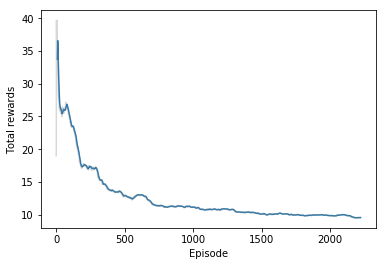

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

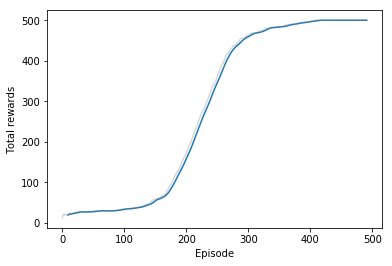

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

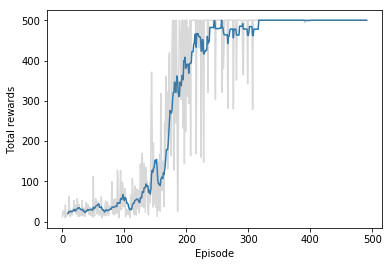

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.